In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score , RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

from xgboost import XGBClassifier

import shap
from shap import TreeExplainer


# 0. Set preliminaries

In [2]:
# Define the scoring metric with the positive label specified
# Depression = 1
scorer = make_scorer(f1_score, pos_label=1) 

In [3]:
# Set display settings: Turning off scientific notation and getting max column width displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# 1. Load in the dataset

In [31]:
df = pd.read_csv('../Data/Combined_sets/data_rq1.tsv', header=[0,1], index_col=[0], sep='\t')


In [6]:
columns_list = df.columns.to_list()
# Remove the label column
columns_list = columns_list[:-1]

In [7]:
# Check
print(columns_list)

[('gender', 'male'), ('gender', 'female'), ('age', '19-29'), ('age', '30-39'), ('age', '<=18'), ('age', '>=40'), ('Affect', 'mean_NA'), ('Affect', 'NAV'), ('Affect', 'mean_affect'), ('Affect', 'AV'), ('Affect', 'mean_PA'), ('Affect', 'PAV'), ('Tweet_Count', 'timeline'), ('Tweet_Count', 'sd_words'), ('Tweet_Count', 'min_words'), ('Tweet_Count', 'max_words'), ('Tweet_Count', 'mean_punct'), ('Tweet_Count', 'mean_exclam'), ('Tweet_Count', 'log_punct'), ('Tweet_Count', 'log_exclam'), ('Tweet_Count', 'mentions_p'), ('Emojis', 'mean_emoji'), ('Emojis', 'log_total_emoji'), ('Emojis', 'neg_emoji_p'), ('Emojis', 'pos_emoji_p'), ('CDS_prevalence', 'labeling_mislabeling'), ('CDS_prevalence', 'catastrophising'), ('CDS_prevalence', 'dichotomous_reasoning'), ('CDS_prevalence', 'emotional_reasoning'), ('CDS_prevalence', 'disqualifying_positive'), ('CDS_prevalence', 'magnification_minimisation'), ('CDS_prevalence', 'mental_filtering'), ('CDS_prevalence', 'mindreading'), ('CDS_prevalence', 'fortunetelli

In [8]:
df = df.fillna(0)

# 2. Dataset split and scaling

In [9]:
y = df[("target", "diagnosis")]
X = df.drop([("target", "diagnosis")], axis=1)

In [10]:
# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.15, random_state=42, 
                                                  stratify=y_train)

## 2.2 Scaling

In [11]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


# 3. Random Forest Performance

We used RandomizedSearchCV, so to control for the randomization, we set n_iter to 100 and repeated the model fit 10 times, then taking the best result and hyperparameters from those.

### 1

In [ ]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)

print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 2

In [14]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)
print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 3

In [15]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=scorer,  # Or any other appropriate scoring metric
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)

print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 4

In [16]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)
print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 5

In [17]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)
print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 6

In [18]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)
print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 7

In [19]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)


# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)
print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 8

In [20]:
# Define the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric with the positive label specified
# Ensure the pos_label is the encoded value for 'depression'
#scorer = make_scorer(f1_score, pos_label=le.transform(['depression'])[1])


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=scorer,  # Or any other appropriate scoring metric
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)



# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)

print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 9

In [21]:
# Define the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric with the positive label specified
# Ensure the pos_label is the encoded value for 'depression'
#scorer = make_scorer(f1_score, pos_label=le.transform(['depression'])[1])


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=scorer,  # Or any other appropriate scoring metric
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)



# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)

print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best f1 score found:  0.9088488866496192
Test accuracy of the best model:  0.9277777777777778
Test precision of the best model:  0.8921568627450981
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9333333333333333


### 10

In [26]:
# Initialise the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [500],
    'learning_rate': [0.1],
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [1.0],
    'colsample_bytree': [0.9],
    'reg_alpha': [0.01],
    'reg_lambda': [1.5]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer, 
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best f1 score found: ", random_search.best_score_)

# Evaluate the best model on the test data
best_xgb_model = random_search.best_estimator_
importance = best_xgb_model.feature_importances_
y_pred = best_xgb_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Test accuracy of the best model: ", accuracy)
print("Test precision of the best model: ", precision)
print("Test recall of the best model: ", recall)
print("Test f1 score of the best model: ", f1)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}
Best f1 score found:  0.910278940815784
Test accuracy of the best model:  0.9305555555555556
Test precision of the best model:  0.896551724137931
Test recall of the best model:  0.978494623655914
Test f1 score of the best model:  0.9357326478149101


Confusion Matrix

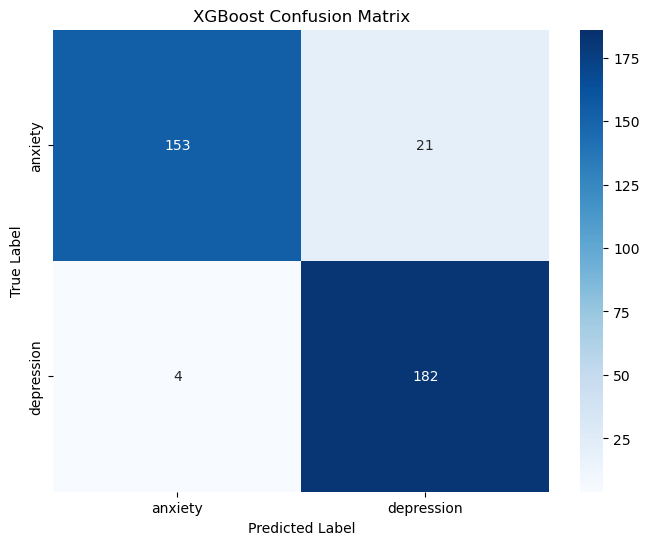

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['anxiety', 'depression'], yticklabels=['anxiety', 'depression'],vmax=186)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

# RQ2: Feature importances

SHAP calculation with LinearExplainer

In [28]:
# explain all the predictions in the test set
explainer_xgb = shap.TreeExplainer(best_xgb_model, X_train)

# Compute SHAP values for the test set
shap_values_xgb = explainer_xgb.shap_values(X_test)

Beeswarm plot for positive depression class, top 20

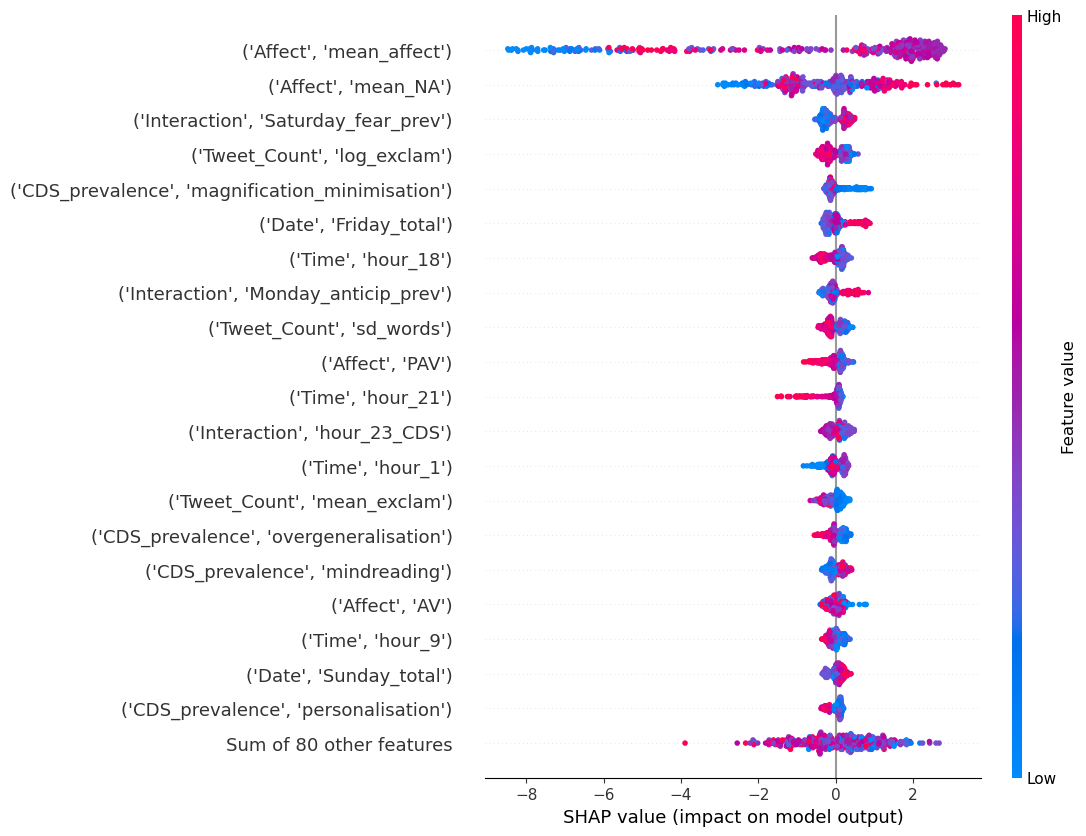

In [29]:
# Get feature names from X_train.columns (assuming X_train is a DataFrame)
feature_names_xgb = columns_list

# Ensure shap_values_rf is a list of arrays for binary classification
# and we select the values for the 'depression' class (assuming it's class 1)
if isinstance(shap_values_xgb, list) and len(shap_values_xgb) == 2:
    # Assuming 'depression' is the positive class, typically at index 1
    values_for_plot_xgb = shap_values_xgb[1]
    base_value_xgb = explainer_xgb.expected_value[1]
else:
    # If it's not a list, assume it's a single 2D array for binary classification
    values_for_plot_xgb = shap_values_xgb
    base_value_xgb = explainer_xgb.expected_value

# Create a shap.Explanation object
shap_explanation_xgb = shap.Explanation(
    values=values_for_plot_xgb,
    base_values=base_value_xgb,
    data=X_test, # Convert DataFrame to numpy array if X_test is a DataFrame
    feature_names=feature_names_xgb
)

# Now call shap.plots.beeswarm with the Explanation object
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_xgb, max_display=21)

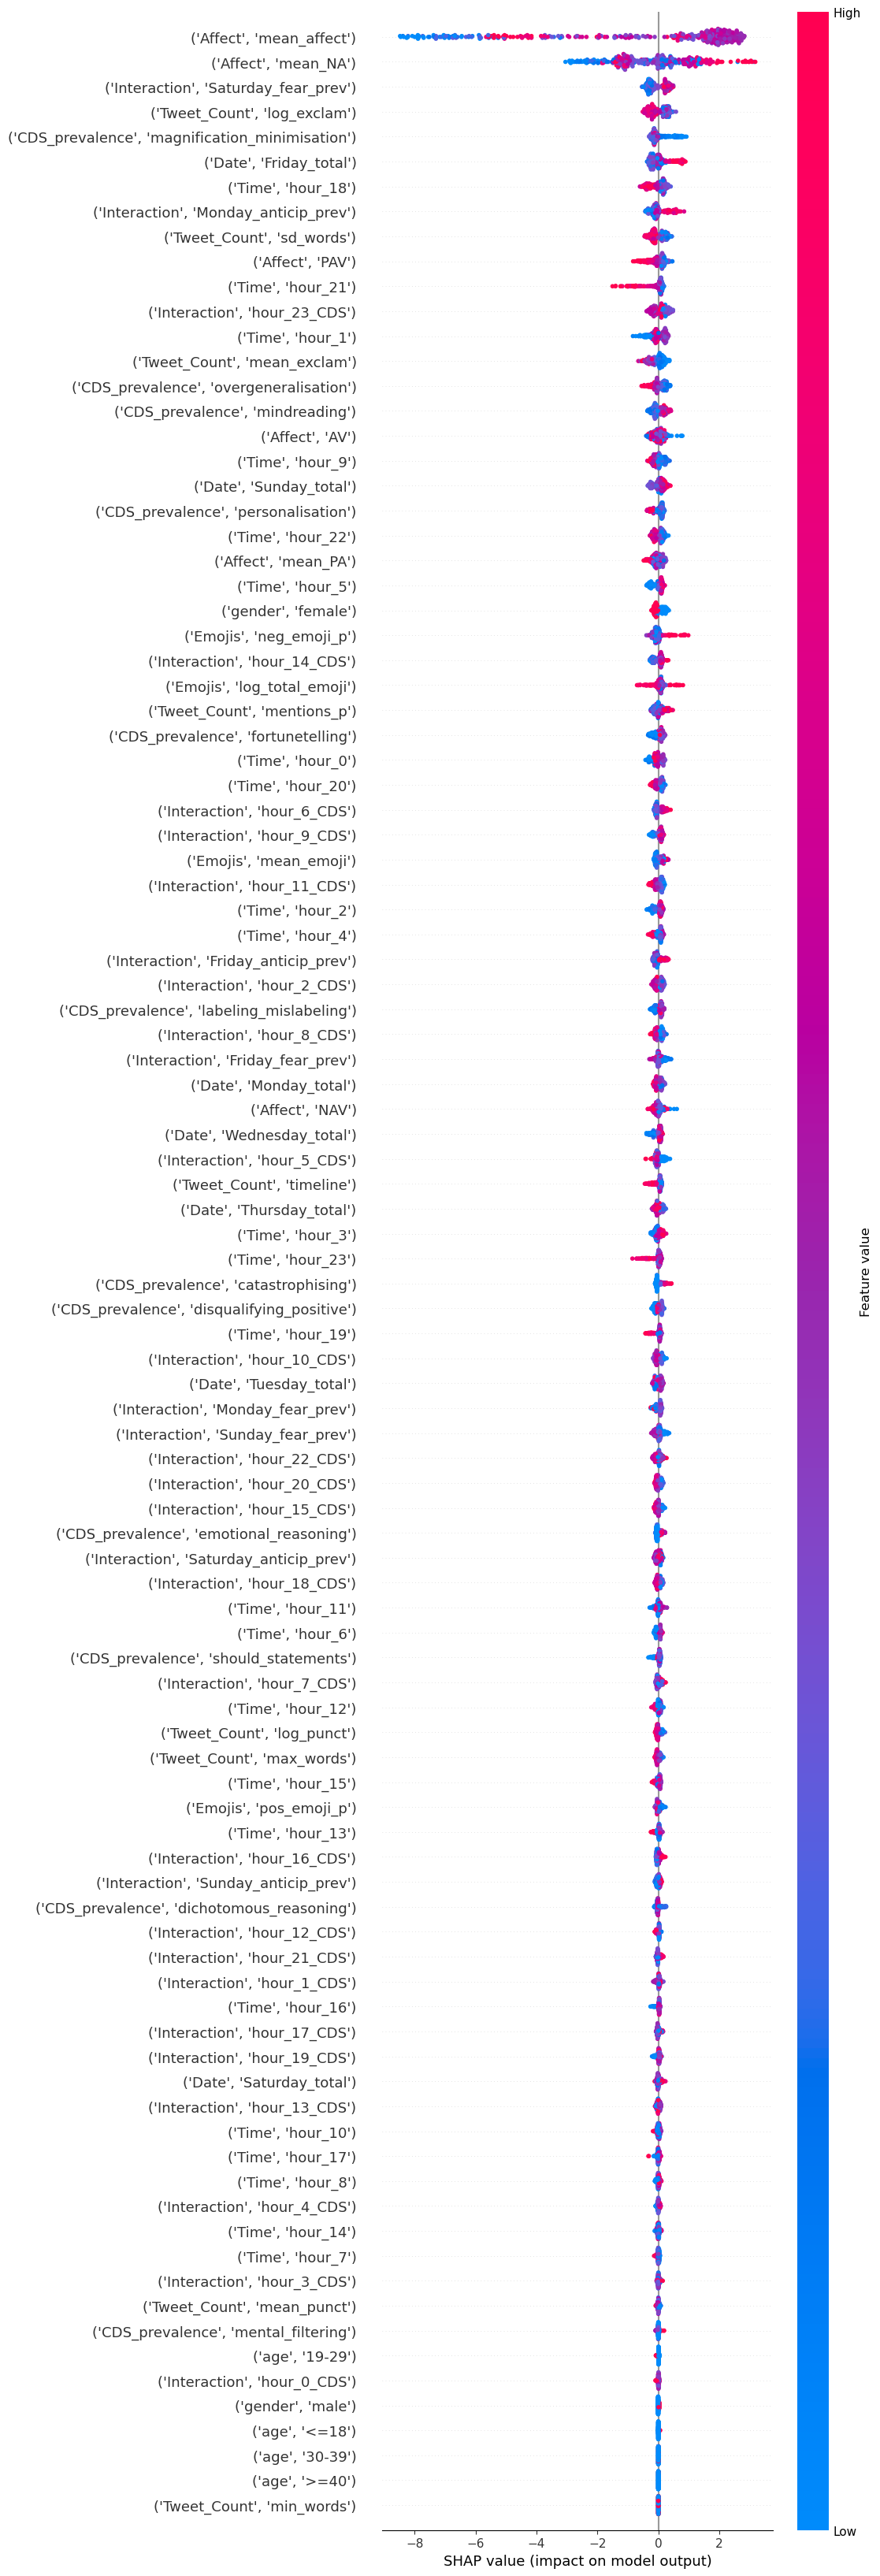

In [30]:
# Get feature names from X_train.columns (assuming X_train is a DataFrame)
feature_names_xgb = columns_list

# Ensure shap_values_rf is a list of arrays for binary classification
# and we select the values for the 'depression' class (assuming it's class 1)
if isinstance(shap_values_xgb, list) and len(shap_values_xgb) == 2:
    # Assuming 'depression' is the positive class, typically at index 1
    values_for_plot_xgb = shap_values_xgb[1]
    base_value_xgb = explainer_xgb.expected_value[1]
else:
    # If it's not a list, assume it's a single 2D array for binary classification
    values_for_plot_xgb = shap_values_xgb
    base_value_xgb = explainer_xgb.expected_value

# Create a shap.Explanation object
shap_explanation_xgb = shap.Explanation(
    values=values_for_plot_xgb,
    base_values=base_value_xgb,
    data=X_test, # Convert DataFrame to numpy array if X_test is a DataFrame
    feature_names=feature_names_xgb
)

# Now call shap.plots.beeswarm with the Explanation object
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_xgb, max_display=100)